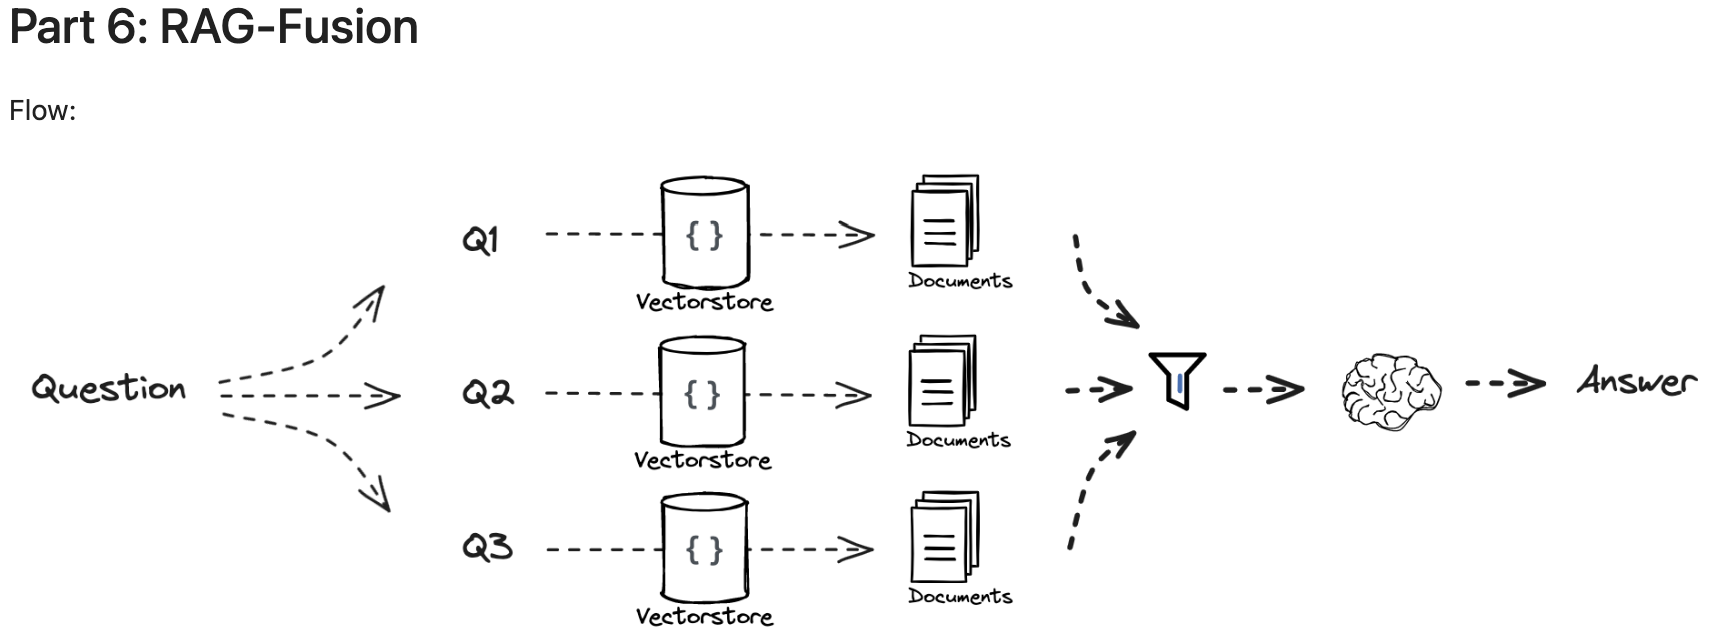

In [ ]:
from langchain.prompts import ChatPromptTemplate

import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(documents)

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()


# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""

prompt_rag_fusion = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

# generate_queries.invoke("What is task decomposition for LLM agents?")

In [ ]:
from langchain.load import dumps, loads
def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        for rank, doc_ex in enumerate(docs):
            doc_str = dumps(doc_ex)
            if doc_str not in fused_scores:
                    fused_scores[doc_str] = 0
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [(loads(doc), score) for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)]
    return reranked_results

In [ ]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
question = "What is task decomposition for LLM agents?"

llm = ChatOpenAI()
final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": RunnablePassthrough()} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})